In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import btb.utils.tools as btbtools
import btb.utils.wikiquery as wq

import mwclient
import pickle
from collections import defaultdict

In [86]:
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

In [87]:
from IPython.display import Image

In [3]:
wikiEN = mwclient.Site('en.wikipedia.org')
# wikiEN = btbtools.getDebugWiki()
bots = wq.getAllBots(wikiEN)
expEdPct = wq.getTotalContributions() # Expected percentage of edits per country

In [4]:
def randomTitles(wikiEN, nTitles):
    '''
    Generator of random Wikipedia pages.
    '''
    for i in range(int(nTitles/10)):
        randPages = wikiEN.random(namespace=0, limit=10)
        for page in randPages:
            yield page['title']

In [5]:
def categoryTitles(wikiEN, catName, nTitles):
    '''
    Generator of random Wikipedia pages in a category.
    
    NOTE: ordering of items in the category is always the same.
    
    eg: categoryTitles(wikiEN, 'Cities in the Netherlands', 20)
    '''
    wikiCat = wikiEN.categories[catName]
    for i in range(nTitles):
        catPage = wikiCat.next()
        yield catPage.name

In [67]:
def unpackContributions(cmpEdits):
    ''' previously dict comprehension: 
    { ctry: ac for ctry,(ex,ac,cm) in cmpEdits.iteritems() } 
    
    except added an if  to avoid empty keys which cause problems 
    when pickling '''
    edits = {}
    for ctry,(ex,ac,cm) in cmpEdits.iteritems():
        if ctry=='':
            ctry = '_'
        edits[ctry] = ac
    return edits

def fetchContributions(titles):
    '''
    Parameters:
        titles    Generator of titles to be fetched
    Return:
        dictionary of title: contribution percentages
    '''
    # TODO: Maybe make into a generator ?
    cumEdPct = []
    for pageTitle in titles:
        ips, usrs, nrevs = wq.getContributionsForPage(wikiEN, pageTitle)
        revCount, conf, nIP, nUsr, nBot, nUnkn = btbtools.prepareData(ips, usrs, bots)

        cmpEdits = btbtools.compareEdits(expEdPct, revCount)
        actEdPct = unpackContributions(cmpEdits)
        cumEdPct.append((pageTitle, actEdPct))
    return cumEdPct

In [7]:
def getContributionSummary(pageContribs):
    # Normalization factor:
    # Weight each contribution by a normalization factor dependent on the 
    # total weight of all contributions
    normFactor = sum( sum(contribs.values()) for title,contribs in pageContribs )
    
    edPct = defaultdict(float)
    for title,pageEdPct in pageContribs:
        for ctry,pct in pageEdPct.iteritems():
            edPct[ctry] += pct / normFactor
    edPct = dict(edPct)
    return edPct


In [20]:
def getEditError(globalContribs):
    editDiff = []
    for e in expEdPct:
        ex = expEdPct[e]
        ac = globalContribs[e] if e in globalContribs else 0
        editDiff.append(ac-ex)
    editDiff = np.array(editDiff)
    return (editDiff**2).sum()

# Fetch data from Wikipedia

In [78]:
titles = randomTitles(wikiEN, 500)
pageContribs = fetchContributions(titles)
pickle.dump(pageContribs, open('PageContribsRandom.pkl', 'w'))

In [14]:
titles = categoryTitles(wikiEN, 'Cities in the Netherlands', 500)
pageContribs = fetchContributions(titles)
pickle.dump(pageContribs, open('PageContribs_citiesNL.pkl', 'w'))

In [ ]:
titles = randomTitles(wikiEN, 1000)
pageContribs = fetchContributions(titles)
pickle.dump(pageContribs, open('PageContribsRandom1000A.pkl', 'w'))

# Plot data

In [16]:
def getErr(pageContribs, n):
    contribsN = pageContribs[:n]
    return getEditError(getContributionSummary(contribsN))

def plotContribError(pageContribs):
    nSamples = range(1,len(pageContribs))
    err = [ getErr(pageContribs, n_i) for n_i in nSamples ]
    semilogy(nSamples,err)
    axis([ 0, len(pageContribs), 0, 1]);

In [28]:
def plotHistogramContributions(pageContribs, fig=None):
    if fig==None:
        figure(figsize=(12,4))

    actEdPct = getContributionSummary(pageContribs)

    tags   = np.array(expEdPct.keys())
    cmpVals = np.array(expEdPct.values())

    # Sort descending by expected value
    sortIdx = cmpVals.argsort()
    sortIdx = sortIdx[::-1]
    tags   = tags[sortIdx]

    expVal = [ expEdPct[ctry] for ctry in tags ]
    actVal = [ actEdPct[ctry] for ctry in tags ]

    # Format bar charts
    width = 0.35
    N = len(tags)
    ind = np.arange(N)

    bar(ind           , expVal, width=width, color='y', label='Expectation')
    bar(ind + width   , actVal, width=width, color='r', label='Contribution')
    xticks(ind + width, tags  , rotation=90)

In [91]:
def makeFrame(i, pageContribs):
    gcf().clear()
    plotHistogramContributions(pageContribs[:i], gcf())
    title('Title %d'%i)
    img = mplfig_to_npimage(gcf())
    return img

def wrapMakeFrame(f, pageContribs, fps):
    i = int(f * fps)+1
    return makeFrame(i, pageContribs)

def buildAnimation(pageContribs, aniFile, duration):
    fps = len(pageContribs) / duration
    print 'We have to display %f frames each second, so in %d seconds, we display %d frames'%(fps, duration, len(pageContribs))
    
    fig = figure(figsize=(12,4))
    
    lambdaMakeFrame = lambda f: wrapMakeFrame(f, pageContribs, fps)

    animation =mpy.VideoClip(lambdaMakeFrame, duration=duration)
    animation.write_gif(aniFile, fps=fps)
    close()

## 500 random Wikipedia pages

In [80]:
pageContribs = pickle.load(open('PageContribsRandom.pkl', 'r'))

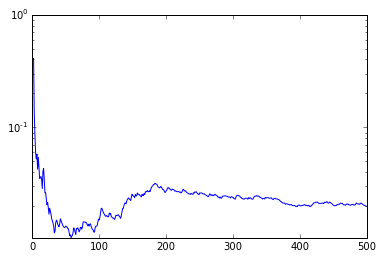

In [81]:
plotContribError(pageContribs)

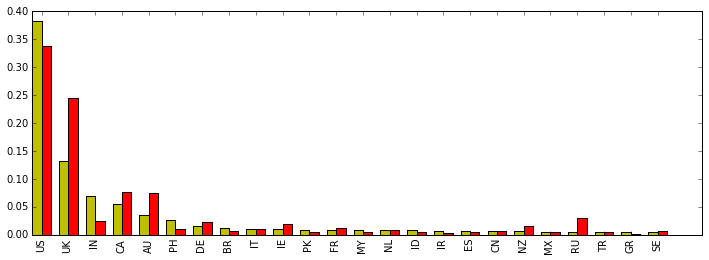

In [82]:
plotHistogramContributions(pageContribs)

In [ ]:
buildAnimation(pageContribs, 'random.gif', duration=50)

In [88]:
Image(url='cities_nl.gif')

## Category: cities in the netherlands

In [ ]:
pageContribs = pickle.load(open('PageContribs_citiesNL.pkl', 'r'))

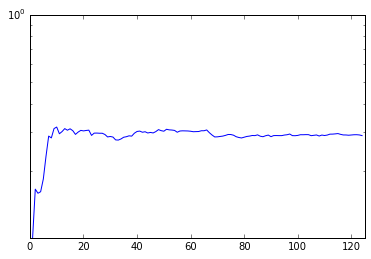

In [21]:
plotContribError(pageContribs)

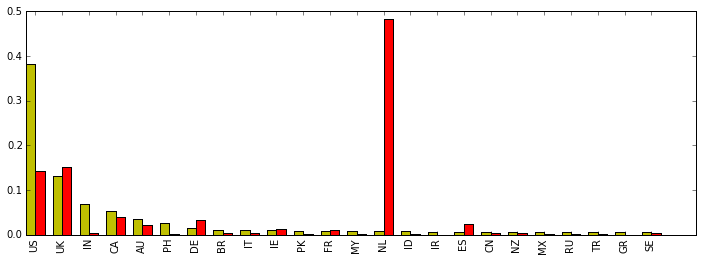

In [22]:
plotHistogramContributions(pageContribs)

In [ ]:
buildAnimation(pageContribs, 'cities_nl.gif', duration=20)

In [90]:
Image(url='random.gif')